# Many imports and functions

In [7]:
import random as rand
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2

RANDOM_SEED = 8927

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
def read_ground_truths(path, did):
    """Path is the path to the GROUND TRUTH folder"""
    aij = pd.read_csv(os.path.join(path, "interaction_coefficients", f"dataset_{did}_aij.csv"))
    gr = pd.read_csv(os.path.join(path, "growth_rates", f"dataset_{did}_growth_rates.csv"))
    return (aij, gr)


def load_all_ground_truths(path):
    gt_dict = {}
    for did in range(total_n_dids):
        aij, gr = read_ground_truths(path, did)

        aij = aij.set_index("focal_species").values
        gr = gr.set_index("species").values.reshape(-1)

        gt_dict[str(did)] = (aij, gr)

    return gt_dict


def calculate_ED_score(truth_aij, inferred_aij) -> float:
    """GRANT'S edited version to calculate ED score

    Calculate the ecological direction (EDₙ) score (n := number of species in ecosystem).

    Parameters
    ===============
    truth: pandas.DataFrame(index=species_names, columns=species_names), the ecosystem coefficient matrix used to generate data
    inferred: pandas.DataFrame(index=species_names, columns=species_names), the inferred ecosystem coefficient matrix
    Returns
    ===============
    ED_score: float
    """

    truth = pd.DataFrame(truth_aij).copy()
    inferred = pd.DataFrame(inferred_aij).copy()

    # consider inferred coefficients
    mask = inferred != 0

    # compare sign: agreement when == -2 or +2, disagreement when 0
    nonzero_sign = np.sign(inferred)[mask] + np.sign(truth)[mask]
    corr_sign = (np.abs(nonzero_sign) == 2).sum().sum()
    opposite_sign = (np.abs(nonzero_sign) == 0).sum().sum()

    # count incorrect non-zero coefficients
    wrong_nz = (truth[mask] == 0).sum().sum()

    # combine
    unscaled_score = corr_sign - 2 * opposite_sign - 0.5 * wrong_nz

    # scale by theoretical extrema
    truth_nz_counts = (truth != 0).sum().sum()
    truth_z_counts = len(truth.index) ** 2 - truth_nz_counts
    theoretical_min = -2 * truth_nz_counts - 0.5 * truth_z_counts
    theoretical_max = truth_nz_counts

    # EDₙ score scaled between 0 and 1
    ED_score = (unscaled_score - theoretical_min) / (theoretical_max - theoretical_min)

    return ED_score


def calc_dlogydt(x, times):
    """x: an n_timepoints long column vector, from one timeseries, of one species
    times: an n_timepoints long column vector of corresponding timepoints

    returns: (dlogydts, dts, times)
    """

    n_intervals = len(x) - 1

    dlogydts = []
    dts = []
    valid_idxs = set()

    for i in range(n_intervals):

        # Check if valid interval
        validity_check = x[i] > 0 and x[i + 1] > 0
        if validity_check:

            # Calculate dt, dlogydt
            dt = times[i + 1] - times[i]
            dts.append(dt)

            dlogydt = (np.log(x[i + 1]) - np.log(x[i])) / dt
            dlogydts.append(dlogydt)

            # Save valid indices
            valid_idxs.update([i, i + 1])

        else:
            pass

    # Return empty arrays if all else fails
    if len(dlogydts) <= 0:
        # Return empty arrays
        return (np.array([]), np.array([]), np.array([]), np.array([], dtype=bool))
    else:

        valid_idxs_list = list(valid_idxs)
        times = times[valid_idxs_list].copy()
        times = np.array(times)
        dlogydts = np.array(dlogydts)
        dts = np.array(dts)

        return (dlogydts, dts, times, valid_idxs_list)


def old_calc_dlogydt(x, times):
    nonzero_mask = x > 0
    valid_interval_idx = np.arange(len(x))[nonzero_mask]
    x = x[nonzero_mask].copy()
    times = times[nonzero_mask].copy()

    n_intervals = len(x) - 1

    # Only triggers if the timeseries is entirely negative
    # or if there's only one valid time point (no intervals)
    if n_intervals <= 0:
        # Return empty arrays
        return (np.array([]), np.array([]), np.array([]), np.array([], dtype=bool))

    dlogydts = np.ones(n_intervals)
    dts = np.ones(n_intervals)
    valid_interval_mask = np.ones(n_intervals)

    # For each interval
    for i in range(n_intervals):
        dt = times[i + 1] - times[i]
        dts[i] = dt

        dlogydt = (np.log(x[i + 1]) - np.log(x[i])) / dt
        dlogydts[i] = dlogydt

    return (dlogydts, dts, times, valid_interval_idx)


def calc_xgeom(X):
    """X: an n_timepoints x n_species large matrix, from one timeseries
    I don't actually use this function lol
    """

    n_intervals = X.shape[0] - 1
    n_species = X.shape[1]

    geom_means = np.ones((n_intervals, n_species))
    valid_interval_idx = np.ones((n_intervals, n_species))

    for i in range(n_species):
        cur_species = X[:, i]

        for j in range(n_intervals):
            gmean = np.sqrt(cur_species[j] * cur_species[j + 1])
            geom_means[j, i] = gmean

            # Save for use with dlogydt later
            if cur_species[j] <= 0 or cur_species[j + 1] <= 0:
                valid_interval_idx[j, i] = False

    return (geom_means, valid_interval_idx)


def regress(X_geom, y):
    reg = LinearRegression().fit(X_geom, y)

    return reg


def load_dataset(csv):
    """from csv filepath to full_df, X"""
    full_df = pd.read_csv(csv).drop(columns="Unnamed: 0")

    species_labels = full_df.columns[full_df.columns.str.contains("species_")]
    X = full_df[species_labels].values

    time = full_df.iloc[:, 0].values

    # meta specific
    meta_spec = full_df.iloc[:, -8::]

    return full_df, time, X, meta_spec


def mimic_load_dataset(full_df):
    species_labels = full_df.columns[full_df.columns.str.contains("species_")]
    X = full_df[species_labels].values

    time = full_df.iloc[:, 0].values

    # meta specific
    meta_spec = full_df.iloc[:, -8::]

    return full_df, time, X, meta_spec


def infer_from_did(full_df, debug=False):
    """Returns  inferred, info (if debug=True)"""
    full_df, time_series, X, meta_spec = mimic_load_dataset(full_df)

    codes = meta_spec["timeseries_id"].astype("category").cat.codes.values

    # Calculate the dlogydts for each species
    # Saved as an list of arrays

    n_timepoints, n_species = X.shape

    dlogydt = {}
    dt = {}
    times = {}
    nz_masks = {}
    gmeans = {}

    # (dlogydts, dts, times)

    # FOR EVERY TIMESERIES INDIVIDUALLY
    for i_code in range(len(np.unique(codes))):
        mask = codes == i_code
        cur_timeseries = X[mask].copy()  # Get individual timeseries

        cur_n_intervals = cur_timeseries.shape[0] - 1

        # Create list object to hold calculated quantities PER SPECIES
        dlogydt[i_code] = []
        dt[i_code] = []
        times[i_code] = []
        nz_masks[i_code] = []
        gmeans[i_code] = []

        # Loop over all species in this individual timeseries
        for i_species in range(n_species):

            # Calculate dlogydt, dt, times, nz_masks #
            x, y, z, m = calc_dlogydt(cur_timeseries[:, i_species], time_series[mask])

            dlogydt[i_code].append(x)
            dt[i_code].append(y)
            times[i_code].append(z)
            #         nz_masks[i_code].append(m)

            # Calculate geom_mean #
            cur_species = cur_timeseries[:, i_species]

            # For each individal interval (pair of timepoints)
            gmeans_tmp = np.ones(cur_n_intervals)
            valid_int_idx_tmp = np.ones(cur_n_intervals, dtype=bool)

            for j in range(cur_n_intervals):
                cur_gmean = np.sqrt(cur_species[j] * cur_species[j + 1])
                gmeans_tmp[j] = cur_gmean

                if cur_species[j] <= 0 or cur_species[j + 1] <= 0:
                    valid_int_idx_tmp[j] = False

            gmeans[i_code].append(gmeans_tmp)
            nz_masks[i_code].append(valid_int_idx_tmp)

    # Turn into dfs because that's easy for me
    cols = pd.Index(range(len(np.unique(codes))), name="timeseries_id")
    idx = pd.Index(range(X.shape[1]), name="species_id")

    df_times = pd.DataFrame(times, columns=cols, index=idx)

    df_dlogydt = pd.DataFrame(dlogydt, columns=cols, index=idx)

    df_nzmask = pd.DataFrame(nz_masks, columns=cols, index=idx, dtype=bool)

    df_geom = pd.DataFrame(gmeans, columns=cols, index=idx)

    n_species = X.shape[1]

    regs = []
    intercepts = []
    slopes = []

    # For debugging if needed
    info = dict(dlogydts=[], masks=[], gmeans=[], species=[], shapes=[])

    for focal_species in range(n_species):

        # Get the y to be predicted
        cur_dlogydt = np.concatenate(df_dlogydt.loc[focal_species].values)
        cur_mask = np.concatenate(df_nzmask.loc[focal_species].values)

        # Get the X to predict, only take valid intervals
        cur_gmeans = np.array(
            [np.concatenate(df_geom.loc[i, :].values) for i in range(n_species)]
        ).T

        cur_gmeans = cur_gmeans[cur_mask, :].copy()

        # Update debug info
        info["dlogydts"].append(cur_dlogydt)
        info["masks"].append(cur_mask)
        info["gmeans"].append(cur_gmeans)
        info["species"].append(focal_species)
        info["shapes"].append(
            dict(dlogydt=cur_dlogydt.shape, mask=cur_mask.shape, gmeans=cur_gmeans.shape)
        )

        # If focal_species has no intervals, return NaNs for inferred.
        if len(cur_dlogydt) == 0:
            regs.append(np.nan)
            slopes.append(np.repeat(np.nan, n_species))
            intercepts.append(np.array([np.nan]))

        # Otherwise, regress.
        else:
            try:
                reg = LinearRegression().fit(cur_gmeans, cur_dlogydt)
            except ValueError:
                return ("broken", did, info)

            regs.append(reg)
            intercepts.append(reg.intercept_)
            slopes.append(reg.coef_)

    # Return all solutions!

    # make em arrays
    slopes = np.vstack(slopes)
    intercepts = np.vstack(intercepts)

    inferred = (slopes, intercepts)

    if debug:
        return (inferred, info)
    else:
        return inferred


def _heatmap(
    truth_aij,
    inferred_aij,
    base_figsize=(3, 3),
):
    # lazy
    aij = truth_aij
    slopes = inferred_aij

    fig, (ax1, ax2, cbar_ax) = easy_subplots(
        ncols=3, base_figsize=base_figsize, gridspec_kw=dict(width_ratios=[1, 1, 0.05], wspace=0)
    )

    sns.heatmap(aij, center=0, square=True, annot=True, cmap="coolwarm", ax=ax1, cbar_ax=cbar_ax)
    sns.heatmap(slopes, center=0, square=True, annot=True, cmap="coolwarm", ax=ax2, cbar_ax=cbar_ax)
    ax1.set_title("Ground truth")
    ax2.set_title("Inferred")

    plt.tight_layout()

    return fig, (ax1, ax2, cbar_ax)


def calculate_es_score(truth_aij, inferred_aij) -> float:
    """GRANT'S edited version to calculate ED score

    Calculate the ecological direction (EDₙ) score (n := number of species in ecosystem).

    Parameters
    ===============
    truth: pandas.DataFrame(index=species_names, columns=species_names), the ecosystem coefficient matrix used to generate data
    inferred: pandas.DataFrame(index=species_names, columns=species_names), the inferred ecosystem coefficient matrix
    Returns
    ===============
    ED_score: float
    """

    truth = pd.DataFrame(truth_aij).copy()
    inferred = pd.DataFrame(inferred_aij).copy()

    # consider inferred coefficients
    mask = inferred != 0

    # compare sign: agreement when == -2 or +2, disagreement when 0
    nonzero_sign = np.sign(inferred)[mask] + np.sign(truth)[mask]
    corr_sign = (np.abs(nonzero_sign) == 2).sum().sum()
    opposite_sign = (np.abs(nonzero_sign) == 0).sum().sum()

    # count incorrect non-zero coefficients
    wrong_nz = (truth[mask] == 0).sum().sum()

    # combine
    unscaled_score = corr_sign - 2 * opposite_sign

    # scale by theoretical extrema
    truth_nz_counts = (truth != 0).sum().sum()
    truth_z_counts = len(truth.index) ** 2 - truth_nz_counts
    theoretical_min = -2 * truth_nz_counts
    theoretical_max = truth_nz_counts

    ED_score = (unscaled_score - theoretical_min) / (theoretical_max - theoretical_min)

    return ED_score

# Analysis

## just random values

In [9]:
RAND = np.random.RandomState(RANDOM_SEED)

def gen_nostruc_df():
    species_abundances = np.abs(RAND.randn(100, 3))
    timeseries_ids = [874701, 312388, 152319, 132128, 827141]

    tid_list = np.array([], dtype=int)
    for i_id in timeseries_ids:
        cur_stack = np.repeat(i_id, 20)
        tid_list = np.append(tid_list, cur_stack)

    df = (
        pd.DataFrame(species_abundances, columns=["species_0", "species_1", "species_2"])
        .assign(
            timeseries_id=tid_list,
            n_species=3,
            noise_scale=np.nan,
            n_timeseries=5,
            n_timepoints=20,
            seq_depth="high",
            ground_truth=np.nan,
            sampling_scheme="even",
        )
        .reset_index()
        .rename(columns={"index": "time"})
    )

    df = df[
        [
            "time",
            "species_0",
            "species_1",
            "species_2",
            "timeseries_id",
            "noise_scale",
            "n_species",
            "sampling_scheme",
            "n_timeseries",
            "n_timepoints",
            "seq_depth",
            "ground_truth",
        ]
    ]

    return df

In [10]:
nonstruc_dfs = []
full_inferences = []
just_coefs = []
dfs = []
for i in range(10000):
    cur_df = gen_nostruc_df()
    dfs.append(cur_df)
    
    cur_score = infer_from_did(cur_df)
    nonstruc_dfs.append(cur_df)
    full_inferences.append(cur_score)
    
    just_coefs.append(cur_score[0].reshape(-1))

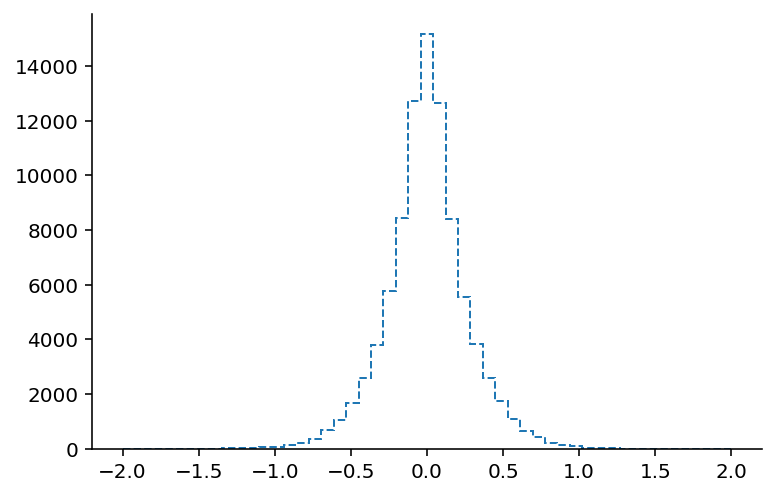

In [11]:
fig, ax = plt.subplots()
ax.hist(np.array(just_coefs).reshape(-1), histtype='step', ls='--', bins=np.linspace(-2, 2, 50))
sns.despine()

Save the datasets

In [14]:
# for i, df in enumerate(dfs):
#     df.to_csv("data/no_time_structure_dataset_{}.csv".format(i))